decomposition.py

🔜 derivatives.py: Compute dy/dx, d²y/dx² per component

🔜 posterior_sampler.py: Sample N functions from posterior

🔜 dataframe_builder.py: Bundle all of it into a DataFrame

In [1]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader

import logging

import gpytorch
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.constraints import GreaterThan


from time_series_generator import SyntheticTimeSeriesGenerator
#from time_series_dataset import TimeSeriesDataset


from gp_kernel_factory import KernelBuilder

from curriculum_selector import CurriculumSelector


from exact_gp_model import ExactGPModel


from exact_gp_trainer import ExactGPTrainer
from frozen_kernel_predictor import FrozenKernelPredictor
#from decomposition import GPDecomposer

import matplotlib.pyplot as plt


# prod

In [2]:
# Generate 10 synthetic time series (some low signal)
generator = SyntheticTimeSeriesGenerator(
    num_series=1000,
    series_length=500,
    trend_types=["long_term", "short_term", "seasonal"],
    noise_level=0.1,
    min_value=0.0,
    low_signal_ratio=0.01,
    low_signal_scale=0.1,
    seed=42
)
df = generator.generate()


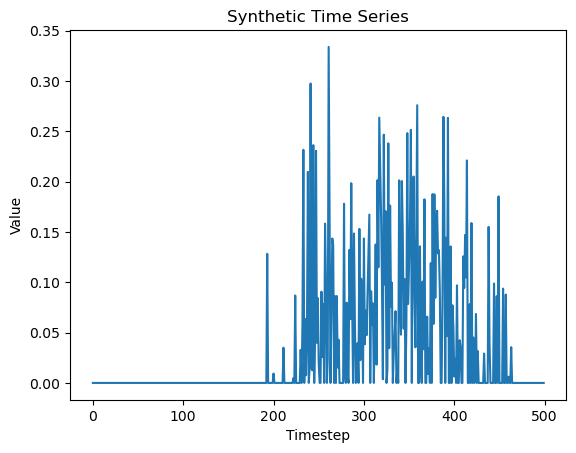

In [3]:
time_series_id = np.random.choice(df.series_id.unique(), 1)[0]
ts_df = df[df.series_id == time_series_id] # for testing
train_x = torch.tensor(ts_df["timestep"].values, dtype=torch.float32).unsqueeze(-1)  # shape [T, 1]
train_y = torch.tensor(ts_df["value"].values, dtype=torch.float32)  

plt.plot(ts_df["timestep"], ts_df["value"])
plt.title("Synthetic Time Series")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.show()

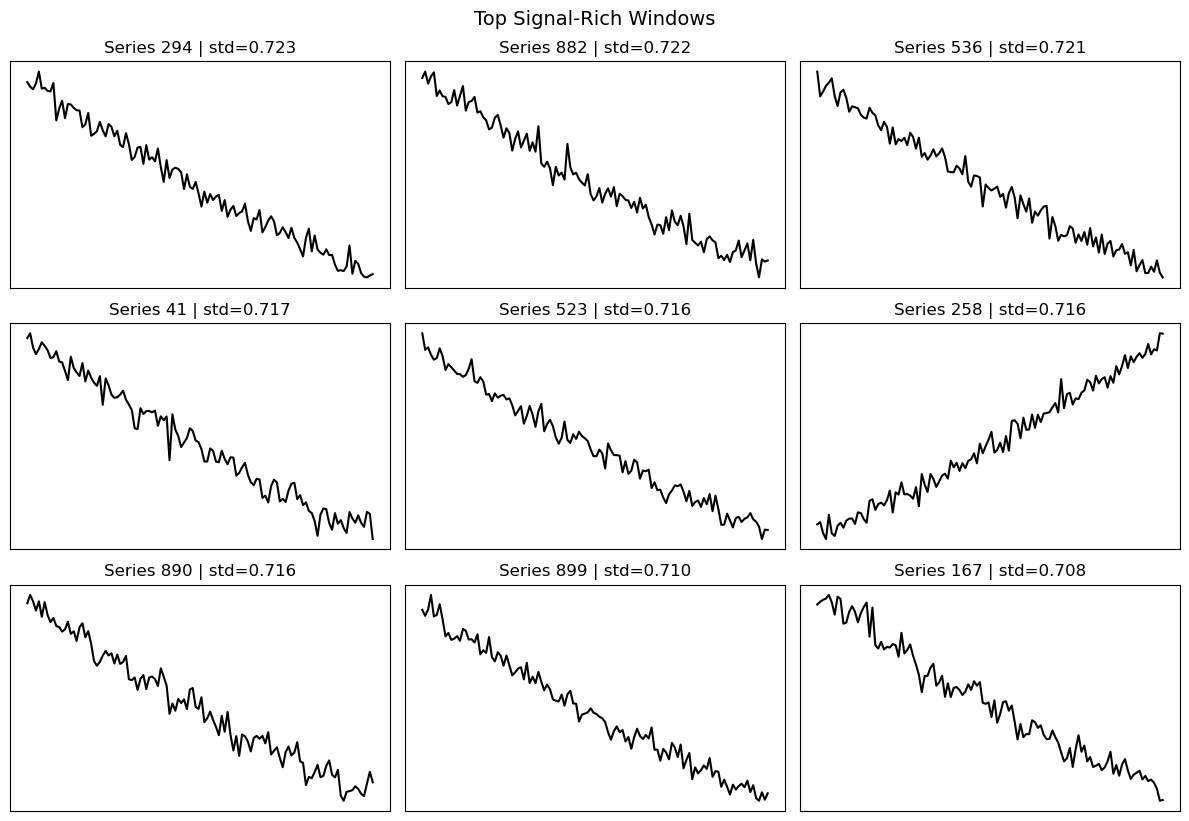

x_train shape: torch.Size([36000, 1])
y_train shape: torch.Size([36000])


In [4]:
selector = CurriculumSelector(df, window_length=120, stride=5, signal_metric="std", top_k=300)
selector.plot_sample_slices(num_samples=9)

x_list, y_list = selector.to_tensor_dataset()

x_train = torch.cat(x_list)
y_train = torch.cat(y_list)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

In [5]:
simple_kernel_config = {
    "type": "scale",
    "outputscale": 1.0,
    "outputscale_prior": {"mean": 1.0, "stddev": 0.5},
    "base_kernel": {
        "type": "RBF",
        "lengthscale": 0.3,
        "lengthscale_prior": {"mean": 0.5, "stddev": 0.2}
    }
}



In [6]:
advance_kernel_config = {
    "type": "add",
    "components": [
        {
            "type": "scale",
            "outputscale": 0.5,
            "outputscale_prior": {"mean": 0.5, "stddev": 0.3},
            "base_kernel": {
                "type": "Matern",
                "nu": 2.5,
                "lengthscale": 24.0,  # long-term trend
                "lengthscale_prior": {"mean": 36.0, "stddev": 12.0}
            }
        },
        {
            "type": "scale",
            "outputscale": 0.3,
            "outputscale_prior": {"mean": 0.3, "stddev": 0.2},
            "base_kernel": {
                "type": "RBF",
                "lengthscale": 5.0,
                "lengthscale_prior": {"mean": 5.0, "stddev": 2.0}
            }
        },
        {
            "type": "scale",
            "outputscale": 0.3,
            "outputscale_prior": {"mean": 0.3, "stddev": 0.1},
            "base_kernel": {
                "type": "Periodic",
                "period_length": 12.0,
                "period_length_prior": {"mean": 12.0, "stddev": 2.0},
                "lengthscale": 3.0,
                "lengthscale_prior": {"mean": 4.0, "stddev": 1.0}
            }
        }
    ]
}



In [7]:
advance_kernel_config = {
    "type": "add",
    "components": [
        {
            "type": "scale",
            "outputscale": 0.5,
            "outputscale_prior": {"mean": 0.5, "stddev": 0.3},
            "base_kernel": {
                "type": "Matern",
                "nu": 2.5,
                "lengthscale": 24.0,  # long-term trend
                "lengthscale_prior": {"mean": 36.0, "stddev": 12.0}
            }
        },
        {
            "type": "scale",
            "outputscale": 0.3,
            "outputscale_prior": {"mean": 0.3, "stddev": 0.2},
            "base_kernel": {
                "type": "RBF",
                "lengthscale": 5.0,
                "lengthscale_prior": {"mean": 5.0, "stddev": 2.0}
            }
        },
        {
            "type": "scale",
            "outputscale": 0.3,
            "outputscale_prior": {"mean": 0.3, "stddev": 0.1},
            "base_kernel": {
                "type": "Periodic",
                "period_length": 12.0,
                "period_length_prior": {"mean": 12.0, "stddev": 2.0},
                "lengthscale": 3.0,
                "lengthscale_prior": {"mean": 4.0, "stddev": 1.0}
            }
        }
    ]
}

In [8]:
advance_kernel_config = {
    "type": "add",
    "components": [
        {
            "type": "scale",
            "outputscale": 1.0,
            "base_kernel": {"type": "RBF", "lengthscale": 80.0}  # long-term
        },
        {
            "type": "scale",
            "outputscale": 1.0,
            "base_kernel": {"type": "RBF", "lengthscale": 10.0}  # short-term
        },
        {
            "type": "scale",
            "outputscale": 0.5,
            "base_kernel": {
                "type": "Periodic",
                "lengthscale": 3.0,
                "period_length": 12.0
            }
        }
    ]
    
}

In [9]:
# advance_kernel_config = {
#     "type": "add",
#     "components": [
# 
#         {
#             "type": "scale",
#             "outputscale": 0.3,
#             "outputscale_prior": {"mean": 0.3, "stddev": 0.2},
#             "base_kernel": {
#                 "type": "RBF",
#                 "lengthscale": 5.0,
#                 "lengthscale_prior": {"mean": 5.0, "stddev": 2.0}
#             }
#         },
#         {
#             "type": "scale",
#             "outputscale": 0.3,
#             "outputscale_prior": {"mean": 0.3, "stddev": 0.1},
#             "base_kernel": {
#                 "type": "Periodic",
#                 "period_length": 12.0,
#                 "period_length_prior": {"mean": 12.0, "stddev": 2.0},
#                 "lengthscale": 3.0,
#                 "lengthscale_prior": {"mean": 4.0, "stddev": 1.0}
#             }
#         }
#     ]
# }

In [10]:
advance_kernel_config = {
    "type": "add",
    "components": [
        {
            "type": "scale",
            "outputscale": 1.0,
            "base_kernel": {
                "type": "RBF",
                "lengthscale": 100.0,
                "lengthscale_prior": {"mean": 100.0, "stddev": 20.0}
            }
        },
        {
            "type": "scale",
            "outputscale": 0.5,
            "base_kernel": {
                "type": "Matern",
                "nu": 1.5,
                "lengthscale": 10.0,
                "lengthscale_prior": {"mean": 10.0, "stddev": 3.0}
            }
        },
        {
            "type": "scale",
            "outputscale": 0.4,
            "base_kernel": {
                "type": "Periodic",
                "lengthscale": 3.0,
                "period_length": 12.0,
                "period_length_prior": {"mean": 12.0, "stddev": 2.0}
            }
        }
    ]
}


In [11]:
# Instantiate and constrain
likelihood = GaussianLikelihood()
likelihood.noise = torch.tensor(1e-1)



In [12]:

model = ExactGPModel(
    train_x=train_x,
    train_y=train_y,
    likelihood=likelihood,
    kernel_config= advance_kernel_config,
    use_mvp_kernel=False,
    mean_type="zero"
)


🔧 ExactGPModel configuration:
  • Mean       : ZeroMean
  • Kernel     : AdditiveKernel
    - Composite of : ['ScaleKernel', 'ScaleKernel', 'ScaleKernel']




In [13]:
KernelBuilder(advance_kernel_config).log_kernel_structure()

AdditiveKernel
[Component 0]
  ScaleKernel
    RBFKernel
    lengthscale: 100.0000
  outputscale: 1.0000
[Component 1]
  ScaleKernel
    MaternKernel
    lengthscale: 10.0000
  outputscale: 0.5000
[Component 2]
  ScaleKernel
    PeriodicKernel
    lengthscale: 3.0000
    period: 12.0000
  outputscale: 0.4000


In [14]:
# set logging level to info
logging.basicConfig(level=logging.INFO)

print(f"Initial noise: {likelihood.noise.item():.4f}")

trainer = ExactGPTrainer(
    model=model,
    likelihood=likelihood,
    train_x=train_x,
    train_y=train_y,
    lr=0.003,
    max_grad_norm=1.0
)

trainer.train(num_epochs=1000)

print(f"Final noise: {likelihood.noise.item():.4f}")


Initial noise: 0.1000


/home/simon/anaconda3/envs/gpytorch_2025/lib/python3.9/site-packages/torch/_compile.py:32: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)
INFO:exact_gp_trainer:[Epoch 001] Loss: 0.070049
INFO:exact_gp_trainer:Noise: 0.0994311049580574
INFO:exact_gp_trainer:[Epoch 025] Loss: 0.009613
INFO:exact_gp_trainer:Noise: 0.08667067438364029
INFO:exact_gp_trainer:[Epoch 050] Loss: -0.053449
INFO:exact_gp_trainer:Noise: 0.07506435364484787
INFO:exact_gp_trainer:[Epoch 075] Loss: -0.116442
INFO:exact_gp_trainer:Noise: 0.06498216092586517
INFO:exact_gp_trainer:[Epoch 100] Loss: -0.179210
INFO:exact_gp_trainer:Noise: 0.05624298378825188
INFO:exact_gp_trainer:[Epoch 125] Loss: -0.241681
INFO:exact_gp_trainer:Noise: 0.048681046813726425
INFO:exact_gp_trainer:[Epoch 150] Loss: -0.303725
INFO:exact_gp_trainer:Noise: 0.04214683547616005
IN

Final noise: 0.0025


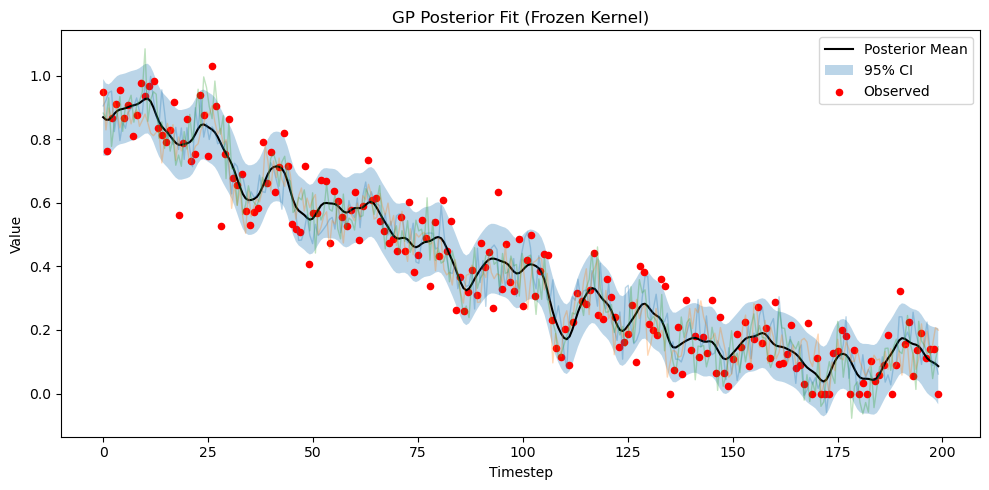

INFO:frozen_kernel_predictor:[Decomposition] Adjustment enabled (adjust=True)
INFO:frozen_kernel_predictor:[Decomposition] Adjustment enabled (adjust=True)
INFO:frozen_kernel_predictor:[Decomposition] Adjustment enabled (adjust=True)


[Integrity Check] Max abs diff: 0.02807 | Mean abs diff: 0.00616
❌ Decomposition mismatch — investigate kernels or scaling ❌


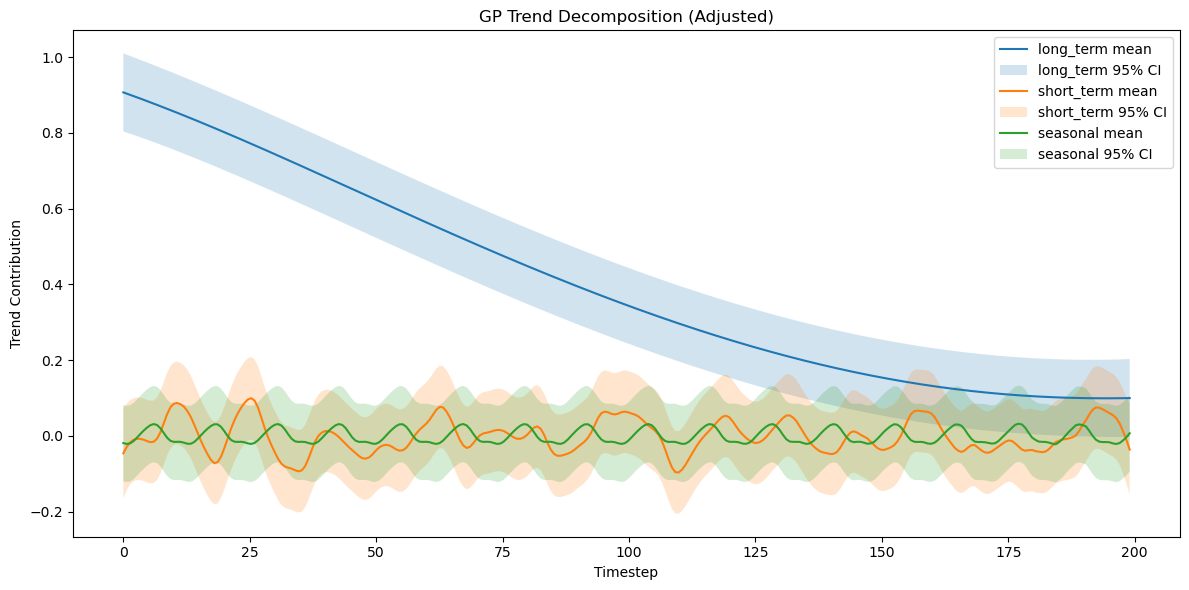

In [15]:
# === Select an unseen time series ===
ts_id = np.random.choice(df.series_id.unique())
ts_df_infer = df[df.series_id == ts_id].copy().iloc[:200]  # Optional slicing

x_infer = torch.tensor(ts_df_infer["timestep"].values, dtype=torch.float32).unsqueeze(-1)
y_infer = torch.tensor(ts_df_infer["value"].values, dtype=torch.float32)

# === Define predictor using frozen kernel & trained likelihood ===
predictor = FrozenKernelPredictor(
    kernel=model.covar_module,
    likelihood=likelihood,  # reuse trained likelihood
    component_names=["long_term", "short_term", "seasonal"]
)

predictor.infer(x_infer, y_infer)

# Optional: freeze for multiprocessing reuse
frozen_clone = predictor.freeze()

# === Evaluation grid
x_grid = torch.linspace(x_infer.min(), x_infer.max(), 300).unsqueeze(-1)

# === Plot full fit with posterior samples ===
predictor.plot_fit(x_grid, show_samples=True, num_samples=3)

# === Decomposition (with adjusted components for interpretability) ===
decomp = predictor.posterior_decomposition(x_grid, adjust=True)

# ✅ Integrity check (after adjustment)
predictor.check_decomposition_integrity(x_grid, adjust=True)

# === Plot each decomposed component ===
predictor.plot_decomposition(x_grid, num_samples=0, adjust=True)


In [16]:
df_trend = predictor.to_dataframe(x_grid, adjust=True)
print(df_trend.shape)
df_trend.head()


INFO:frozen_kernel_predictor:[to_dataframe] adjust=True
INFO:frozen_kernel_predictor:[Decomposition] Adjustment enabled (adjust=True)


(300, 14)


,timestep,full_mean,full_lower,full_upper,long_term_mean,long_term_lower,long_term_upper,short_term_mean,short_term_lower,short_term_upper,seasonal_mean,seasonal_lower,seasonal_upper,observed
0,0.000000,0.869582,0.749445,0.989720,0.906785,0.803727,1.009842,-0.046161,-0.165386,0.073065,-0.019116,-0.119796,0.081564,0.949564
1,0.665552,0.861651,0.747309,0.975994,0.903605,0.800732,1.006478,-0.029133,-0.143013,0.084746,-0.021240,-0.121906,0.079426,NaN
2,1.331104,0.861495,0.750093,0.972897,0.900396,0.797698,1.003094,-0.017276,-0.128237,0.093685,-0.019840,-0.120504,0.080824,NaN
3,1.996655,0.869428,0.759249,0.979607,0.897159,0.794627,0.999691,-0.010463,-0.120083,0.099158,-0.013990,-0.114654,0.086674,NaN
4,2.662207,0.880420,0.770644,0.990195,0.893900,0.791526,0.996274,-0.007809,-0.116941,0.101324,-0.005146,-0.105810,0.095519,NaN


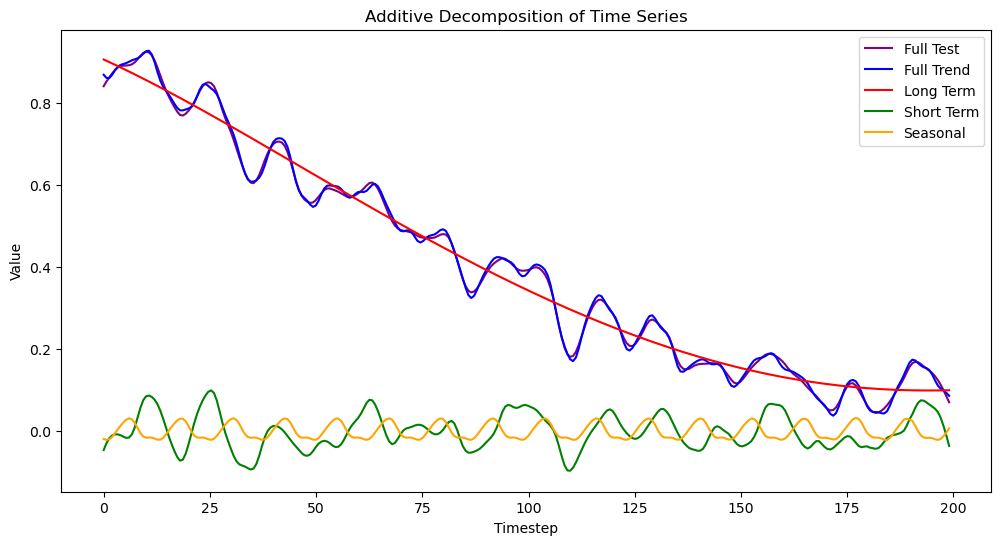

In [17]:
mean_trend = df_trend["full_mean"].values

mean_long_term = df_trend["long_term_mean"].values
mean_seasonal = df_trend["seasonal_mean"].values #  - df_trend["seasonal_mean"].values.mean()
mean_short_term = df_trend["short_term_mean"].values # - mean_long_term - mean_seasonal


full_test = mean_long_term + mean_short_term + mean_seasonal

plt.figure(figsize=(12, 6))
plt.plot(x_grid.numpy(), full_test, label="Full Test", color="purple")
plt.plot(x_grid.numpy(), mean_trend, label="Full Trend", color="blue")
plt.plot(x_grid.numpy(), mean_long_term, label="Long Term", color="red")
plt.plot(x_grid.numpy(), mean_short_term, label="Short Term", color="green")
plt.plot(x_grid.numpy(), mean_seasonal, label="Seasonal", color="orange")
plt.title("Additive Decomposition of Time Series")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()